# DDS Sweeper Tests

In [1]:
import serial
import time
import pyvisa 
import numpy as np
from IPython.display import Image, display

# You will have to change this to whatever COM port the pico is assigned when
# you plug it in.
# On Windows you can open device manager and look at the 'Ports (COM & LPT)' dropdown
# the pico will show up as 'USB Serial Device'
PICO_PORT = 'COM3'

MHZ = 1000000

# without images, entire notebook takes ~40s
SAVE_IMAGES = True
SHOW_IMAGES = True

In [2]:
# helper for sending serial commands
# expects a string with the command (they dont have to be escaped with \r or \n at the end)
# if echo is set to false, that means not to worry about the response from the
# pico it signifigantly reduces communication time when sending many
# instructions, but you lose out on the debugging info from the pico
def send(command: str, echo = True) -> str:
    # pico is expecting a newline to end every command
    if command[-1] != '\n':
        command += '\n'

    resp = ''
    conn = None
    try:
        conn = serial.Serial(PICO_PORT, baudrate = 152000, timeout = 0.1)
        conn.write(command.encode())
        if echo:
            resp = conn.readlines()
            resp = "".join([s.decode() for s in resp])

    except Exception as e:
        print("Encountered Error: ", e)

    finally:
        conn.close()

    return resp


## Test Serial Communication with the Pico

In [3]:
assert send('reset')    == 'ok\n'
assert send('status')   == '0\n'
assert send('version')  == '0.2.1\n'
print('Serial Communication Successful')

Serial Communication Successful


## Test Register Readback

In [4]:
# Helper for reading register values and putting them in a dictionary
# takes in the frequency of the reference clock, assuming default of 125 MHz
def readregs(ref_clk = 125 * MHZ) -> dict:
    ad9959 = {}

    regs = send('readregs')
    regs = regs.split('\n')
    # strip out register labels
    regs = [''.join(r.split()[1:]) for r in regs]

    # convert from hex to decimal
    for i, reg in enumerate(regs):
        try:
            regs[i] = int(reg, 16)
        except ValueError:
            pass

    # mask and shift to pull out PLL Multiplier from fr1
    ad9959['pll_mult'] = (regs[1] & 0x7c0000) >> 18

    # will need system clock to find the frequencies from the tuning words
    sys_clk = ref_clk * ad9959['pll_mult']

    for i in range(4):
        ad9959[i] = {}

        ftw = regs[5 + 9 * i]
        ad9959[i]['freq'] = ftw / 2**32 * sys_clk

        pow = regs[6 + 9 * i]
        ad9959[i]['phase'] = pow * 360 / 2**14

        acr = regs[7 + 9 * i]
        if acr & 0x001000:
            ad9959[i]['amp'] = (acr & 0x0003ff) / 1023
        else:
            ad9959[i]['amp'] = 1
    
    return ad9959


readregs()


{'pll_mult': 4,
 0: {'freq': 0.0, 'phase': 0.0, 'amp': 1},
 1: {'freq': 0.0, 'phase': 0.0, 'amp': 1},
 2: {'freq': 0.0, 'phase': 0.0, 'amp': 1},
 3: {'freq': 0.0, 'phase': 0.0, 'amp': 1}}

In [5]:
assert send('reset') == 'ok\n', 'Could not run "reset" command'
ad9959 = readregs()
for i in range(4):
    assert ad9959[i]['freq'] == 0
    assert ad9959[i]['phase'] == 0
    assert ad9959[i]['amp'] == 1

send('setfreq 0 100000000')
send('setphase 1 270')
send('setamp 2 0.5')

ad9959 = readregs()

assert abs(ad9959[0]['freq'] - 100 * MHZ) < 1
assert abs(ad9959[1]['phase'] - 270) < 1
assert abs(ad9959[2]['amp'] - 0.5) < 0.01

print('Register Readback Successful')

Register Readback Successful


In [6]:
class KeysightScope:
    """
    Helper class using pyvisa for a USB connected Keysight Oscilloscope 
    """
    def __init__(self, addr='USB?*::INSTR',
                 timeout=1, termination='\n'):
        rm = pyvisa.ResourceManager()
        devs = rm.list_resources(addr)
        assert len(devs), "pyvisa didn't find any connected devices matching " + addr
        self.dev = rm.open_resource(devs[0])
        self.dev.timeout = 15_000 * timeout
        self.dev.read_termination = termination
        self.idn = self.dev.query('*IDN?')
        self.read = self.dev.read
        self.write = self.dev.write
        self.query = self.dev.query

    def _get_screenshot(self, verbose=False):
        if verbose == True:
            print('Acquiring screen image...')
        return(self.dev.query_binary_values(':DISPlay:DATA? PNG, COLor', datatype='s'))

    def save_screenshot(self, filepath, verbose=False, inksaver=False):
        if verbose == True:
            print('Saving screen image...')
        result = self._get_screenshot()

        # Keysight scope defaults to inksaving for image save
        if inksaver == True:
            self.dev.write(':HARDcopy:INKSaver 1')
        else: 
            self.dev.write(':HARDcopy:INKSaver OFF')

        with open(f'{filepath}', 'wb+') as ofile:
            ofile.write(bytes(result))

    def set_time_delay(self, time):
        self.write(f':TIMebase:DELay {time}')

    def set_time_scale(self, time):
        self.write(f':TIMebase:SCALe {time}')

my_instrument = KeysightScope()

## Set Viewing Params

In [7]:
# my_instrument.query('*LRN?')
# my_instrument.query('TIMebase:MODE?')
my_instrument.write(":CHANnel1:DISPlay 1")
my_instrument.write(':ChANnel1:SCALe +250E-03')
my_instrument.write(':ChANnel1:OFFSet -450E-03')

my_instrument.write(":CHANnel2:DISPlay 1")
my_instrument.write(':ChANnel2:SCALe +1.00E+00')
my_instrument.write(':ChANnel2:OFFSet 275E-03')
my_instrument.write(":TRIGger:EDGE:SOURce CHANnel2")

my_instrument.write(":CHANnel3:DISPlay 1")
my_instrument.write(':ChANnel3:SCALe +1.00E+00')
my_instrument.write(':ChANnel3:OFFSet +2.0E+00')

my_instrument.write(":CHANnel4:DISPlay 1")
my_instrument.write(':ChANnel4:SCALe +1.00E+00')
my_instrument.write(':ChANnel4:OFFSet +2.0E+00')

## ensure Source 1 and Source 2 are the outputs of the PFD on your setup
my_instrument.write(':FUNCtion:SOURce1 CHAN3')
my_instrument.write(':FUNCtion:SOURce2 CHAN4')
my_instrument.write(':FUNCtion:OPERation SUBTract')

my_instrument.write(':FUNCtion:OPERation SUBTract')
my_instrument.write(':FUNCtion:OFFSet +500E-03')
my_instrument.write(':FUNCtion:SCALe +1.00E+00')



27

## Manual Testing

### Different Freqs


In [8]:
## source
freq0 = 125 * MHZ # source freq > ref freq
phase0 = 0
amp0 = 1

## reference
freq1 = 85 * MHZ
phase1 = 270
amp1 = 1

send(f'setfreq 0 {freq0}')
send(f'setphase 0 {phase0}')
send(f'setamp 0 {amp0}')

send(f'setfreq 1 {freq1}')
send(f'setphase 1 {phase1}')
send(f'setamp 1 {amp1}')

'ok\n'

### Different Phases


In [9]:
# # send(f"""
# #      abort
# #      mode 0 1
# #      setchannels 1
# #      """)
# ## source
# freq0 = 100 * MHZ # source freq > ref freq
# phase0 = 0
# amp0 = 1

# ## reference
# freq1 = 100 * MHZ
# phase1 = 270
# amp1 = 1

# send(f'setfreq 0 {freq0}')
# send(f'setphase 0 {phase0}')
# send(f'setamp 0 {amp0}')

# send(f'setfreq 1 {freq1}')
# send(f'setphase 1 {phase1}')
# send(f'setamp 1 {amp1}')

'ok\n'

### seti
`seti`
Sets the value of instruction number `addr` for channel `channel` (zero indexed). `addr` starts at 0. It looks different depending on what mode the sweeper is in. If `Debug` is set to `on` it will respond with the actual values set for that instruction. `seti` uses integer values (AD9959 units) rather than floating point values. Otherwise, it is the same as `set`.
  - Single Stepping (mode 0): `seti <channel:int> <addr:int> <frequency:int> <amplitude:int> <phase:int> (<time:int>)`
  - Sweep Mode (modes 1-3): `seti <channel:int> <addr:int> <start_point:int> <end_point:int> <delta:int> <ramp-rate:int> (<time:int>)`

    `start_point` is the value the sweep should start from, and `end_point` is where it will stop. `delta` is the amount that the output should change by every cycle of the sweep clock. In the AD9959, the sweep clock runs at one quarter the system clock. `ramp-rate` is an additional divider that can applied to slow down the sweep clock further, must be in the range 1-255. The types of values expected for `start_point`, `end_point`, and `delta` different depending on the type of sweep  
      - Amplitude Sweeps (mode 1)  
        `start_point` and `end_point` should be integers between 0 and 1023 (inclusive).
      - Frequency Sweeps (mode 2)  
        `start_point`, `end_point`, and `delta` are integers between 0 and $2^{32} - 1$ in units of system clock rate (typically $500$ MHz) over $2^{32}$.
      - Phase Sweeps (mode 3)
        `start_point`, `end_point`, and `delta` are between 0 and 65535 (inclusive).

  - Sweep and Single Stepping Mode (modes 4-6): `set <channel:int> <addr:int> <start_point:int> <end_point:int> <delta:int> <ramp-rate:int> <secondary1:int> <secondary2:int> (<time:int>)`

    These modes perform a linear sweep on one of the parameters, while simulaneously single stepping on the other two parameters.
      - Amplitude Sweeps (mode 4)  
        `secondary1` is the frequency, and `secondary2` is the phase offset.
      - Frequency Sweeps (mode 5)  
        `secondary1` is the amplitude scale factor, and `secondary2` is the phase offset.
      - Phase Sweeps (mode 6)  
        `secondary1` is the amplitude scale factor, and `secondary2` is the frequency.

In [10]:

# def integer_map(old_units: float, unit_type: str) -> int:

#     if "amp" in unit_type.lower():
#         rise = 1023
#         run = 1
#     elif "freq" in unit_type.lower():
#         rise = 2**32 - 1
#         run = 500000000
#     elif "phase" in unit_type.lower():
#         rise = 65535
#         run = 360
#     else:
#         print("Invalid argument")

#     new_units = old_units * (rise / run)

#     # assert type(new_units) == int, "did not cast to int"
#     return(int(new_units))



#############################
#### tuning word helpers ####
#############################

## slightly different logic than the ad9959.c funcs due to python vs c
def get_ftw(freq_out: float, freq_sys: float = 125 * MHZ):

    ftw = (freq_out / freq_sys) * 2**32
    
    return(int(ftw))

def get_pow(phase: float):
    
    pow = round(phase / 360 * (2**14 - 1))

    return pow

def get_asf(amp: float):
    
    asf = round(amp * 1024)

    return asf

### setb
 `setb<start address:int> <instruction count:int>`:  
Bulk setting of instructions in binary. `start address` is the address of the first instruction loaded. `instruction count` instructions will be programmed. If there is not sufficient space for that many instructions, the response will be an error message. Otherwise, the response will be `ready for <byte count:int> bytes`, where `byte count` is the number of bytes the device is expecting. An array of instructions can then be transmitted. Note that all active channels are loaded together. The layout of the instruction array is mode dependent:  
   - Single Stepping (mode 0): `<frequency:int 32> <amplitude:int 16> <phase:int 16>`. Total of 8 bytes per channel per instruction.  
   - Single Stepping (mode 0) with timing: `<frequency:int 32> <amplitude:int 16> <phase:int 16> <time: int 32>`. Total of 12 bytes per channel per instruction.  
   - Amplitude Sweeps (mode 1): `<start amplitude:int 16> <stop amplitude:int 16> <delta:int 16> <rate:int 8>`. Total of 7 bytes per channel per instruction.  
   - Amplitude Sweeps (mode 1) with timing: `<start amplitude:int 16> <stop amplitude:int 16> <delta:int 16> <rate:int 8> <time:int 32>`. Total of 11 bytes per channel per instruction.  
   - Frequency Sweeps (mode 2): `<start frequency:int 32> <stop frequency:int 32> <delta:int 32> <rate:int 8>`. Total of 13 bytes per channel per instruction.  
   - Frequency Sweeps (mode 2) with timing: `<start frequency:int 32> <stop frequency:int 32> <delta:int 32> <rate:int 8> <time:int 32>`. Total of 17 bytes per channel per instruction.  
   - Phase Sweeps (mode 1): `<start phase:int 16> <stop phase:int 16> <delta:int 16> <rate:int 8>`. Total of 7 bytes per channel per instruction.  
   - Phase Sweeps (mode 1) with timing: `<start phase:int 16> <stop phase:int 16> <delta:int 16> <rate:int 8> <time:int 32>`. Total of 11 bytes per channel per instruction.  
   - Amplitude Sweep and Single Stepping (mode 4): `<start amplitude:int 16> <stop amplitude:int 16> <delta:int 16> <rate:int 8> <frequency:int 32> <phase:int 16>`. Total of 13 bytes per channel per instruction.  
   - Amplitude Sweep and Single Stepping (mode 4) with timing: `<start amplitude:int 16> <stop amplitude:int 16> <delta:int 16> <rate:int 8> <frequency:int 32> <phase:int 16> <time:int 32>`. Total of 17 bytes per channel per instruction.  
   - Frequency Sweep and Single Stepping (mode 5): `<start frequency:int 32> <stop frequency:int 32> <delta:int 32> <rate:int 8> <amplitude:int 16> <phase:int 16>`. Total of 17 bytes per channel per instruction.  
   - Frequency Sweep and Single Stepping (mode 5) with timing: `<start frequency:int 32> <stop frequency:int 32> <delta:int 32> <rate:int 8> <amplitude:int 16> <phase:int 16> <time:int 32>`. Total of 21 bytes per channel per instruction.  
   - Phase Sweep and Single Stepping (mode 6): `<start phase:int 16> <stop phase:int 16> <delta:int 16> <rate:int 8> <frequency:int 32> <amplitude:int 16>`. Total of 13 bytes per channel per instruction.  
   - Phase Sweep and Single Stepping (mode 6) with timing: `<start phase:int 16> <stop phase:int 16> <delta:int 16> <rate:int 8> <frequency:int 32> <amplitude:int 16> <time:int 32>`. Total of 17 bytes per channel per instruction.

In [11]:
## "%*s %u %u"
## &start_addr, &ins_count

# send(
# f"""abort
# debug off
# setfreq 0 10000000
# setfreq 1 10000000
# setfreq 2 10000000
# setfreq 3 10000000
# setphase 0 0
# setphase 1 0
# setphase 2 0
# setphase 3 0
# mode 0 1
# setchannels 2
# """)

# print(send(
#     """
# setb 1 3
#     """))
# seti 0 0 0 0 0 0 {t}
# seti 0 1 0 0 0 0 {t}
# seti 0 2 0 0 0 0 {t}
# seti 0 3 0 0 0 0 {t}
# seti 0 4 0 0 0 0 {t}
# seti 0 5 0 0 0 0 {t}
# seti 1 0 0 180 {d} 1 {t}
# seti 1 1 180 90 {d} 1 {t}
# seti 1 2 90 0 {d} 1 {t}
# seti 1 3 0 90 {d} 1 {t}
# seti 1 4 90 180 {d} 1 {t}
# seti 1 5 180 0 {d} 1 {t}
# seti 4 6
# start
# """)


In [12]:
import struct 
def create_setb_command(start_address, instruction_count, instructions):

    ## mode 0 parameters to start
    byte_count = instruction_count * 8

    command_str = f"setb {start_address} {instruction_count}"

    instruction_in_bytes = b''

    # u32 u16 u16
    for freq, amp, phase in instructions:

        instruction_in_bytes += struct.pack('>IHH', freq, amp, phase)

    return command_str, byte_count, instruction_in_bytes


# (freq, amp, phase)
example_instructions = [
    (100000000, 1, 90),
    (120000000, 1, 90)
    # (120000000, 1, 90),
    # (110000000, 1, 90),
    # (100000000, 1, 90),
]

start_addr = 4096
num_instructions = 5

command, byte_count, instruction_bytes = create_setb_command(start_addr, num_instructions, example_instructions)

# send(f'setb 4096 ')
# send(f'setb {command}')
print(instruction_bytes)
# instruction_bytes.decode()

b"\x05\xf5\xe1\x00\x00\x01\x00Z\x07'\x0e\x00\x00\x01\x00Z"


In [13]:
# send('reset')

In [14]:
# dt = np.dtype([('frequency', np.uint32), ('amplitude', np.uint16), ('phase', np.uint8)])

# f1 = get_ftw(freq_out= 100 * MHZ)
# f2 = get_ftw(freq_out= 120 * MHZ)
# f3 = get_ftw(freq_out= 110 * MHZ)

# example_instructions = np.array([(f1, 1023, 90),
#                                  (f2, 500, 90),
#                                  (f3, 1023, 90)]
#                                  , dtype = dt)

# instructions_bytes = example_instructions.tobytes()

# # np.frombuffer(instructions_bytes, dtype = dt)

# my_instrument.write(':DISPlay:ANNotation:TEXT "Testing setb"')

# # send(
# # f"""abort
# # mode 0 1
# # setchannels 2
# # """
# # )
# send(f'setb 0 %d' % len(instructions_bytes))
# send(f'setb {instructions_bytes}')
# # send('setb 4 ') ###### need to figure out how to end table correctly
# send('start')

### Odd problem

In [15]:
# send('reset')
# send('mode 0 1')
# send('setchannels 1')

# print(send('set 0 0 100000000 1 0 500000'))
# print(send('set 4 1')) # this works fine

# send('reset')
# send('mode 0 1')
# send('setchannels 1')

# print(send('set 4 1'))  # this fails
# print(send('set 0 0 100000000 1 0 500000'))

## Test Mode 0: Single Stepping Table Mode

Program a 2000 step table that single steps from 10 MHz to 100 MHz over the course of 2 seconds.
The resulting sweep can easily be seen with a spectrum analyzer. 
It is then automatically executed and checks that all 2000 triggers were processed successfully.

### Single Step Frequency

In [16]:
my_instrument.write(':TIMebase:DELay 20.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-09')
my_instrument.write(":CHANnel2:DISPlay 0")
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 0a: Single Stepping Frequency"')
send('reset')

startPoint = 10 * MHZ
endPoint = 100 * MHZ
totalTime = 2 # sec

spacing = 1000 * 10**(-6) # us
steps = round(totalTime / spacing)
delta = (endPoint - startPoint) / steps

send('debug off')
send('mode 0 1')
send('setchannels 1')

for i in range(steps):
    send(f'set 0 {i} {startPoint + delta * i} 1 0 {spacing * 10**9 / 8}', echo=False)
assert send(f'set 4 {i + 1}') == "ok\n"

print("Table Programmed, Executing")
assert send('start') == 'ok\n', 'Buffered Execution did not start correctly'

if SAVE_IMAGES == True:
    time.sleep(totalTime * (1/3))
    my_instrument.save_screenshot('mode0a-freqstep-during.png')
    time.sleep(totalTime * (2/3))
    my_instrument.save_screenshot('mode0a-freqstep-after.png')
else:
    time.sleep(totalTime)
assert send('numtriggers') == f'{steps}\n', 'Wrong number of triggers processed'
print('Table Executed successfully')



Table Programmed, Executing
Table Executed successfully


### Single Step Amplitude

In [17]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 0b: Single Stepping Amplitude"')

startFreq = 100 * MHZ
startPhase = 0

startPoint = 0
endPoint = 1
totalTime = 2 # sec

spacing = 10000 * 10**(-6) # us
steps = round(totalTime / spacing)
delta = (endPoint - startPoint) / steps

send('debug off')
send('mode 0 1')
send('setchannels 1')

for i in range(steps):
    send(f'set 0 {i} {startFreq} {startPoint + delta * i} {startPhase} {spacing * 10**9 / 8}', echo=False)

assert send(f'set 4 {i + 1}') == "ok\n"

print("Table Programmed, Executing")
assert send('start') == 'ok\n', 'Buffered Execution did not start correctly'
if SAVE_IMAGES == True:
    time.sleep(totalTime * (1/3))
    my_instrument.save_screenshot('mode0b-ampstep-during.png')
    time.sleep(totalTime * (2/3))
    my_instrument.save_screenshot('mode0b-ampstep-after.png')
else:
    time.sleep(totalTime)
assert send('numtriggers') == f'{steps}\n', 'Wrong number of triggers processed'
print('Table Executed successfully')

Table Programmed, Executing
Table Executed successfully


### Single Step Phase

In [18]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 0c: Single Stepping Phase"')

startFreq = 100 * MHZ
startAmp = 1

startPoint = 0
endPoint = 360
totalTime = 2 # sec

spacing = 1000 * 10**(-6) # us
steps = round(totalTime / spacing)
delta = (endPoint - startPoint) / steps

send('debug off')
send('mode 0 1')
send('setchannels 1')

for i in range(steps):
    send(f'set 0 {i} {startFreq} {startAmp} {startPoint + delta * i} {spacing * 10**9 / 8}', echo=False)

assert send(f'set 4 {i + 1}') == "ok\n"

print("Table Programmed, Executing")
assert send('start') == 'ok\n', 'Buffered Execution did not start correctly'
if SAVE_IMAGES == True:
    time.sleep(totalTime * (1/3))
    my_instrument.save_screenshot('mode0c-phasestep-during.png')
    time.sleep(totalTime * (2/3))
    my_instrument.save_screenshot('mode0c-phasestep-after.png')
else:
    time.sleep(totalTime)
assert send('numtriggers') == f'{steps}\n', 'Wrong number of triggers processed'
print('Table Executed successfully')

Table Programmed, Executing
Table Executed successfully


### Test Non-Volatile Storage
Run this test after the previous one to test storing and retrieving table instructions in non-volatile memory that will survive a power cycle.

In [19]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Table Save and Load"')

send('save')

# # destory current table
time.sleep(2)
for i in range(steps):
    send(f'set 0 {i} 0 0 0 0', echo=False)

# load and run table
send('load')
time.sleep(1)
send('mode 0 1')
send('setchannels 1')
send('start')

time.sleep(2)
# assert send('numtriggers') == '2000\n', 'Something went wrong'
print('Table run from non-volatile memory successfully')

if SAVE_IMAGES == True:
    my_instrument.save_screenshot('mode0-recall-last-test.png')

Table run from non-volatile memory successfully


## Mode 1: Amplitude Sweep

### Pico Start

Success


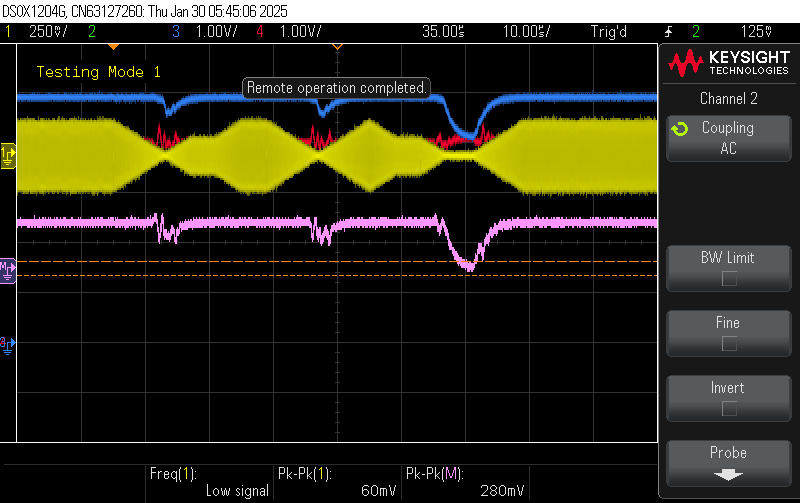

In [20]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 1"')
my_instrument.write(':TIMebase:DELay 35.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-06')

send('reset')

filename = 'mode1-picostart-ampsweep-test.png'

send('debug off')
send(f"""mode 1 1
setchannels 1
setfreq 0 100000000
setfreq 1 100000000
setfreq 2 100000000
setfreq 3 100000000
set 0 0 1.0 0.0 0.001 1 2000
set 0 1 0.0 0.5 0.001 1 2000
set 0 2 0.5 1.0 0.001 1 2000
set 0 3 1.0 0.0 0.001 1 2000
set 0 4 0.0 1.0 0.001 1 2000
set 0 5 1.0 0.5 0.001 1 2000
set 0 6 0.5 0.0 0.001 1 2000
set 0 7 0.0 1.0 0.001 1 2000
set 4 8
start
""")

assert send('numtriggers') == '8\n'
print('Success')
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

### HWStart

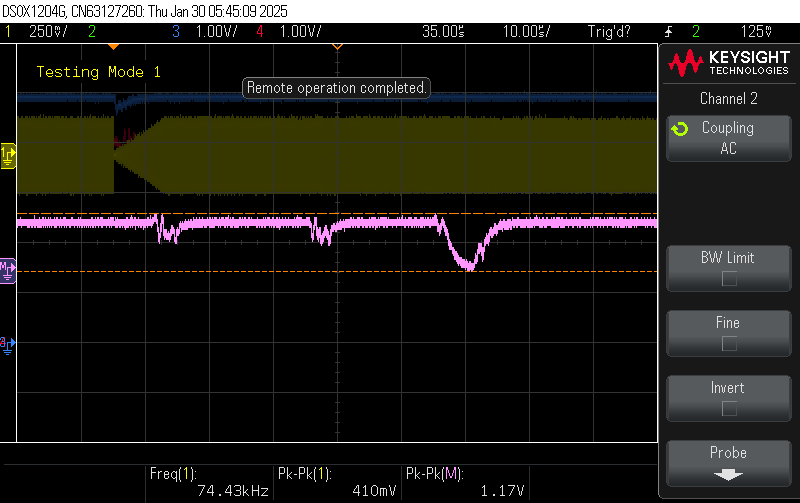

In [21]:
filename = 'mode1-hwstart-ampsweep-test.png'

send('debug off')
send("""abort
mode 1 1
setchannels 1
setfreq 0 100000000
setfreq 1 100000000
setfreq 2 100000000
setfreq 3 100000000
set 0 0 1.0 0.0 0.001 1 2000
set 0 1 0.0 0.5 0.001 1 2000
set 0 2 0.5 1.0 0.001 1 2000
set 0 3 1.0 0.0 0.001 1 2000
set 0 4 0.0 1.0 0.001 1 2000
set 0 5 1.0 0.5 0.001 1 2000
set 0 6 0.5 0.0 0.001 1 2000
set 0 7 0.0 1.0 0.001 1 2000
set 4 8
hwstart
""")

if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

The following is the expected scope trace:  
<img src="amp-test.png" alt="Amplitude Sweep Test on Oscilloscope">  
$D_1$ is the IO_UPDATE line between the pico and the AD9959.  
$D_0$ is the external trigger line into the pico.  
The yellow trace is any of the 4 channel outputs from the AD9959

## Mode 2: Frequency Sweep

### `set`

Success


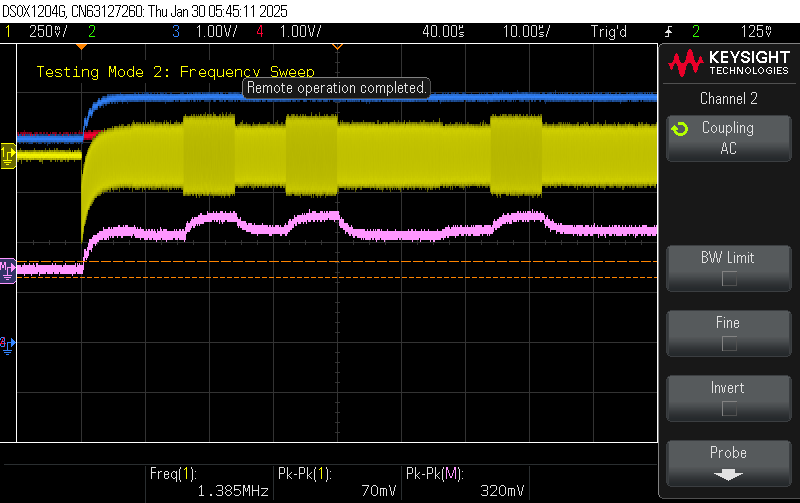

In [22]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 2: Frequency Sweep"')
my_instrument.write(':TIMebase:DELay 40.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-06')
send('reset')

filename = 'mode2-freqsweep-test.png'

# f112 = 112e6
# f115 = 115e6
# f118 = 118e6

f1 = 120e6
f2 = 90e6
f3 = 130e6

d = 2000
t = 3000

send(
f"""abort
mode 2 1
setchannels 1
set 0 0 {f1} {f3} {d * 1} 1 {t * 1}
set 0 1 {f3} {f2} {d / 4} 1 {t * 2}
set 0 2 {f2} {f1} {d * 1} 1 {t / 2}
set 0 3 {f1} {f1} {d * 0} 1 {t * 1}
set 0 4 {f2} {f2} {d * 0} 1 {t * 1}
set 0 5 {f3} {f3} {d * 0} 1 {t * 1}
set 0 6 {f3} {f1} {d * 0} 1 {t * 1}
set 0 7 {f1} {f2} {d / 4} 1 {t * 2}
set 0 8 {f2} {f3} {d * 0} 1 {t * 10}
set 0 9 {f1} {f1} {d * 0} 1 1
set 4 10
start
"""
)

assert send('numtriggers') == '10\n'
print('Success')

if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

The following is the expected scope trace:  
<img src="freq-test.png" alt="Frequency Sweep Example on oscilloscope">  
$D_1$ is the IO_UPDATE line between the pico and the AD9959.  
$D_0$ is the external trigger line into the pico.  
The yellow trace is any of the 4 channel outputs from the AD9959  
The green trace is the output from an interferometer



The following code is for the same trace, but with an external trigger:

In [23]:
send(
f"""abort
mode 2 0
setchannels 1
set 0 0 {f1} {f3} {d} 1 {t}
set 0 1 {f3} {f2} {d} 1 {t}
set 0 2 {f2} {f1} {d} 1 {t}
set 0 3 {f1} {f2} {d} 1 {t}
set 0 4 {f2} {f3} {d} 1 {t}
set 0 5 {f3} {f1} {d} 1 {t}
set 5 6
hwstart
"""
)

'ok\nok\nok\n6\nok\n6\nok\n6\nok\n6\nok\n6\nok\n6\nok\n6\nok\nok\n'

## Mode 3: Phase Sweep

### `set`

Success


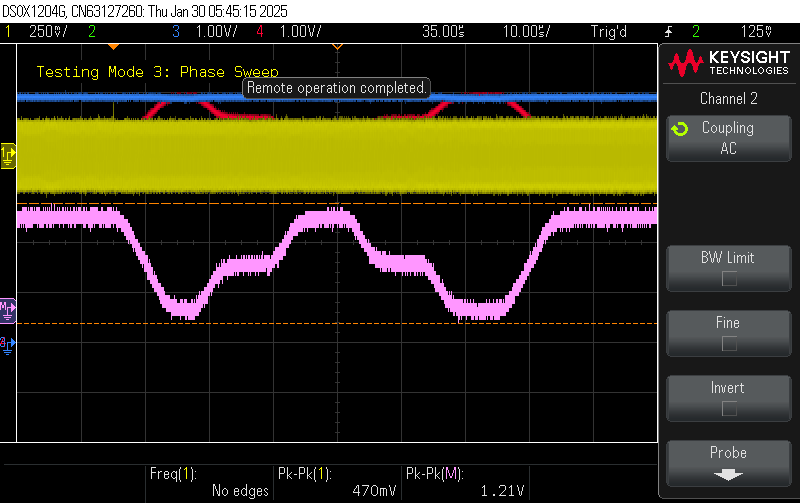

In [24]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 3: Phase Sweep"')
my_instrument.write(':TIMebase:DELay 35.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-06')

my_instrument.write(':FUNCtion:OFFSet +650E-03')
my_instrument.write(':FUNCtion:SCALe +500E-03')
send('reset')

filename = 'mode3-phasesweep-test.png'

t = 2000
d = 0.2

send(f"""abort
debug off
setfreq 0 100000000
setfreq 1 100000000
setfreq 2 100000000
setfreq 3 100000000
setphase 0 0
setphase 1 0
setphase 2 0
setphase 3 0
mode 3 1
setchannels 2
set 0 0 0 0 0 0 {t}
set 0 1 0 0 0 0 {t}
set 0 2 0 0 0 0 {t}
set 0 3 0 0 0 0 {t}
set 0 4 0 0 0 0 {t}
set 0 5 0 0 0 0 {t}
set 1 0 0 180 {d} 1 {t}
set 1 1 180 90 {d} 1 {t}
set 1 2 90 0 {d} 1 {t}
set 1 3 0 90 {d} 1 {t}
set 1 4 90 180 {d} 1 {t}
set 1 5 180 0 {d} 1 {t}
set 4 6
start
""")

assert send('numtriggers') == '6\n'
print('Success')

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

### `seti`

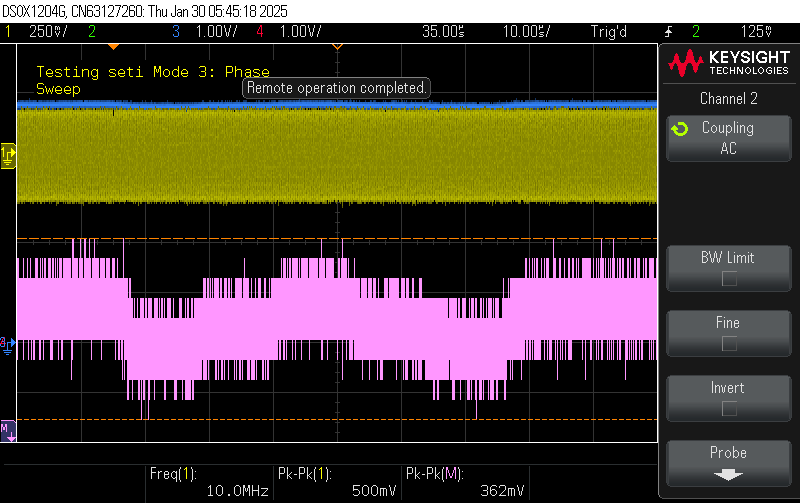

In [25]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing seti Mode 3: Phase Sweep"')
my_instrument.write(':FUNCtion:OFFSet 1.60E-00')
my_instrument.write(':FUNCtion:SCALe +100E-03')
send('reset')

filename = 'mode3-seti-phasesweep-test.png'

t = 2
d = 1

# send(f"""abort
# debug off
# setfreq 0 100000000
# setfreq 1 100000000
# setfreq 2 100000000
# setfreq 3 100000000
# mode 3 1
# setchannels 2
# seti 0 0 0 0 0 0 {t}
# seti 0 1 0 0 0 0 {t}
# seti 0 2 0 0 0 0 {t}
# seti 0 3 0 0 0 0 {t}
# seti 0 4 0 0 0 0 {t}
# seti 0 5 0 0 0 0 {t}
# seti 1 0 0 8192 {d} 1023 {t}
# seti 1 1 8192 4096 {d} 1023 {t}
# seti 1 2 4096 0 {d} 1023 {t}
# seti 1 3 0 4096 {d} 1023 {t}
# seti 1 4 4096 8192 {d} 1023 {t}
# seti 1 5 8192 0 {d} 1023 {t}
# seti 4 6
# start
# """)

### Why does this work but above doesn't? Does seti not properly bypass POW calculation for phasesweeps?
send(f"""abort
debug off
setfreq 0 10000000
setfreq 1 10000000
setfreq 2 10000000
setfreq 3 10000000
setphase 0 0
setphase 1 0
setphase 2 0
setphase 3 0
mode 3 1
setchannels 2
seti 0 0 0 0 0 0 {t}
seti 0 1 0 0 0 0 {t}
seti 0 2 0 0 0 0 {t}
seti 0 3 0 0 0 0 {t}
seti 0 4 0 0 0 0 {t}
seti 0 5 0 0 0 0 {t}
seti 1 0 0 180 {d} 1 {t}
seti 1 1 180 90 {d} 1 {t}
seti 1 2 90 0 {d} 1 {t}
seti 1 3 0 90 {d} 1 {t}
seti 1 4 90 180 {d} 1 {t}
seti 1 5 180 0 {d} 1 {t}
seti 4 6
start
""")

time.sleep(1) # for some reason the math doesn't draw until slightly after
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

This produces the following scope trace:    
<img src="phase-test.png" alt="Phase Sweep Test on Oscilloscope">  
$D_1$ is the IO_UPDATE line between the pico and the AD9959.  
$D_0$ is the external trigger line into the pico.  
The yellow trace is channel 1 from the AD9959  
The pink trace is the output of a phase frequency detector between channels 0 and 1 of the AD9959

## Mode 4: Amplitude Sweep and Single Step Freq, Phase

Success


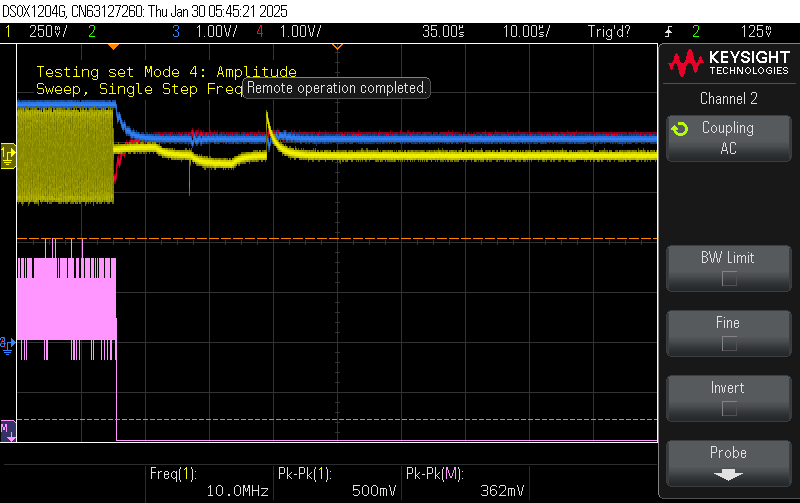

In [26]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing set Mode 4: Amplitude Sweep, Single Step Freq, Phase"')
my_instrument.write(':TIMebase:DELay 35.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-06')

f0 = 150 * MHZ

d = 0.001
t = 2000

filename = 'mode4-ampsweep2-test.png'

# ## set Chan Addr Start Stop Delta Rate Freq Phase Time
# send(
# f"""abort
# mode 4 1
# setchannels 2
# set 0 0 1.0 0.0 {d * 1} 1 {f0} 0 {t}
# set 0 1 0.0 0.5 {d * 1} 1 {f0} 0 {t}
# set 0 2 0.5 1.0 {d * 1} 1 {f0} 0 {t}
# set 0 3 1.0 0.0 {d * 1} 1 {f0} 0 {t}
# set 0 4 0.0 1.0 {d * 1} 1 {f0} 0 {t}
# set 0 5 1.0 0.5 {d * 1} 1 {f0} 0 {t}
# set 0 6 0.5 0.0 {d * 1} 1 {f0} 0 {t}
# set 0 7 0.0 1.0 {d * 1} 1 {f0} 0 {t}
# set 0 8 1.0 0.0 {d * 1} 1 {f0} 0 {t}
# set 0 9 1.0 1.0 {d * 0} 1 {f0} 0 {t}
# set 1 0 1.0 0.0 {d * 0} 1 {f0} 0 {t}
# set 1 1 0.0 0.5 {d * 0} 1 {f0} 0 {t}
# set 1 2 0.5 1.0 {d * 1} 1 {f0} 0 {t}
# set 1 3 1.0 0.0 {d * 1} 1 {f0} 0 {t}
# set 1 4 0.0 1.0 {d * 1} 1 {f0} 0 {t}
# set 1 5 1.0 0.5 {d * 1} 1 {f0} 0 {t}
# set 1 6 0.5 0.0 {d * 1} 1 {f0} 0 {t}
# set 1 7 0.0 1.0 {d * 1} 1 {f0} 0 {t}
# set 1 8 1.0 1.0 {d * 0} 1 {f0} 0 {t}
# set 1 9 1.0 1.0 {d * 0} 1 {f0} 0 {t}
# set 4 10
# start
# """
# )

send(
f"""abort
mode 4 1
setchannels 2
set 0 0 0.1 0.9 {d * 1} 1 {f0} 90 {t}
set 0 1 0.9 0.1 {d * 1} 1 {f0} 90 {t}
set 0 2 0.9 0.9 {d * 0} 1 {f0} 90 {t}
set 1 0 1.0 1.0 {d * 0} 1 {f0} 270 {t}
set 1 1 1.0 1.0 {d * 0} 1 {f0} 270 {t}
set 1 2 1.0 1.0 {d * 0} 1 {f0} 270 {t}
set 4 3
start
"""
)

# assert send('numtriggers') == '4\n'
print('Success')

if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

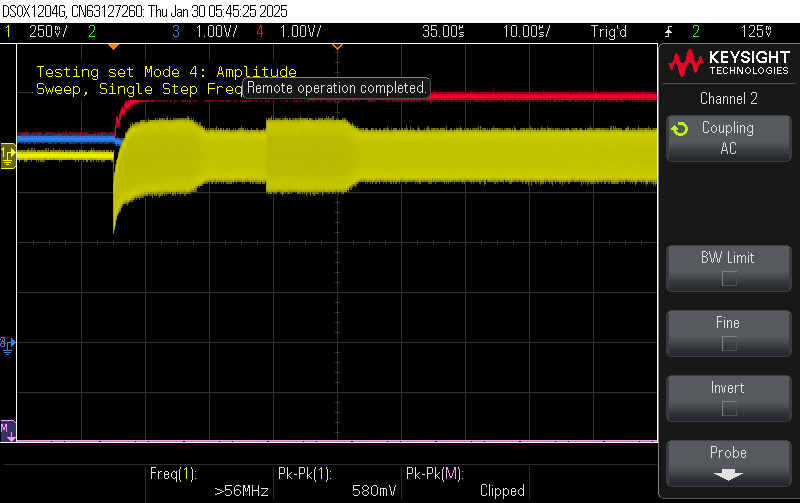

In [27]:
# send('reset')
f2 = get_ftw(freq_out = 100 * MHZ,
             freq_sys = 125 * MHZ)

p2 = get_pow(phase = 270)

d = 1
t = 2

filename = 'mode4-seti-ampsweep2-test.png'

send(
f"""abort
mode 4 1
setchannels 2
seti 0 0 700 1023 {d * 1} 1 {f2} {p2} {t}
seti 0 1 1023 700 {d * 1} 1 {f2} {p2} {t}
seti 0 2 1023 1023 {d * 0} 1 {f2} {p2} {t}
seti 0 3 1023 700 {d * 1} 1 {f2} {p2} {t}
seti 1 0 1023 1023 {d * 1} 1 {f2} {p2} {t}
seti 1 1 1023 1023 {d * 1} 1 {f2} {p2} {t}
seti 1 2 1023 1023 {d * 0} 1 {f2} {p2} {t}
seti 1 3 1023 1023 {d * 1} 1 {f2} {p2} {t}
seti 4 4
start
"""
)

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

## Mode 5: Frequency Sweep and Single Step Amp, Phase

### `set`

Success


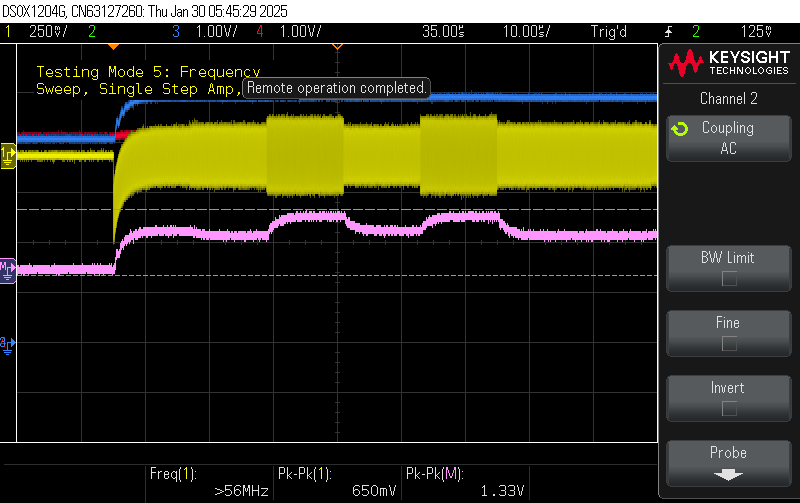

In [28]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 5: Frequency Sweep, Single Step Amp, Phase"')
my_instrument.write(':FUNCtion:OFFSet +0.50E-00')
my_instrument.write(':FUNCtion:SCALe +1.00E-00')
send('reset')

# f1 = 112e6
# f2 = 115e6
# f3 = 118e6

f1 = 120e6
f2 = 90e6
f3 = 130e6

d = .001
t = 2000

filename = 'mode5-freqsweep2-test.png'

# set Chan Addr Start Stop Delta Rate Amp Phase Time

# send(
# f"""abort
# mode 5 1
# setchannels 2
# set 0 0 {f112} {f118} {d}   1 1 0 {t}
# set 0 1 {f118} {f115} {d/4} 1 1 0 {t*2}
# set 0 2 {f115} {f112} {d}   1 1 0 {t/2}
# set 0 3 {f112} {f112} {0}   1 1 0 {t}
# set 0 4 {f115} {f115} {0}   1 1 0 {t}
# set 0 5 {f118} {f118} {0}   1 1 0 {t}
# set 0 6 {f118} {f112} {d}   1 1 0 {t}
# set 0 7 {f112} {f115} {d/4} 1 1 0 {t*2}
# set 0 8 {f115} {f118} {d}   1 1 0 {t*10}
# set 0 9 {f112} {f112}  0    1 1 0 1
# set 1 0 {f112} {f118} {d}   1 0.75 90 {t}
# set 1 1 {f118} {f115} {d/4} 1 0.5  180 {t*2}
# set 1 2 {f115} {f112} {d}   1 0.9  90 {t/2}
# set 1 3 {f112} {f112} {0}   1 1.0  00 {t}
# set 1 4 {f115} {f115} {0}   1 0.9  90 {t}
# set 1 5 {f118} {f118} {0}   1 0.8  180 {t}
# set 1 6 {f118} {f112} {d}   1 0.9  90 {t}
# set 1 7 {f112} {f115} {d/4} 1 1.0  00 {t*2}
# set 1 8 {f115} {f118} {d}   1 0.9  90 {t*10}
# set 1 9 {f112} {f112}  0    1 1.0  90 1
# set 4 10
# start
# """
# )

send(
f"""abort
mode 5 1
setchannels 2
set 0 0 {f1} {f3} {d}   1 0.75 90 {t}
set 0 1 {f3} {f2} {d/4} 1 0.5  180 {t*2}
set 0 2 {f2} {f1} {d}   1 0.9  90 {t/2}
set 0 3 {f1} {f1} {0}   1 1.0  00 {t}
set 0 4 {f2} {f2} {0}   1 0.9  90 {t}
set 0 5 {f3} {f3} {0}   1 0.8  180 {t}
set 0 6 {f3} {f1} {d}   1 0.9  90 {t}
set 0 7 {f1} {f2} {d/4} 1 1.0  00 {t*2}
set 0 8 {f2} {f3} {d}   1 0.9  90 {t*10}
set 0 9 {f1} {f1}  0    1 1.0  90 1
set 1 0 {f1} {f3} {d}   1 1 0 {t}
set 1 1 {f3} {f2} {d/4} 1 1 0 {t*2}
set 1 2 {f2} {f1} {d}   1 1 0 {t/2}
set 1 3 {f1} {f1} {0}   1 1 0 {t}
set 1 4 {f2} {f2} {0}   1 1 0 {t}
set 1 5 {f3} {f3} {0}   1 1 0 {t}
set 1 6 {f3} {f1} {d}   1 1 0 {t}
set 1 7 {f1} {f2} {d/4} 1 1 0 {t*2}
set 1 8 {f2} {f3} {d}   1 1 0 {t*10}
set 1 9 {f1} {f1}  0    1 1 0 1
set 4 10
start
"""
)

assert send('numtriggers') == '10\n'
print('Success')

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

### `seti`

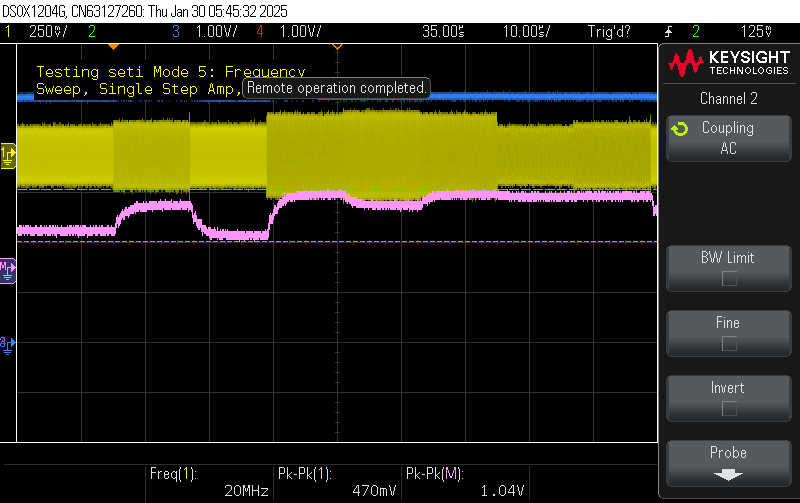

In [29]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing seti Mode 5: Frequency Sweep, Single Step Amp, Phase"')

f1 = get_ftw(freq_out = 112 * MHZ, freq_sys = 125 * MHZ)
f2 = get_ftw(freq_out = 115 * MHZ, freq_sys = 125 * MHZ)
f3 = get_ftw(freq_out = 118 * MHZ, freq_sys = 125 * MHZ)

d = 1
t = 2

filename = 'mode5-seti-freqsweep2-test.png'

send(
f"""abort
mode 5 1
setichannels 2
seti 0 0 {f1} {f3} {d}   1 780 90 {t}
seti 0 1 {f3} {f2} {d/4} 1 500  180 {t*2}
seti 0 2 {f2} {f1} {d}   1 900  90 {t/2}
seti 0 3 {f1} {f1} {0}   1 1023  00 {t}
seti 0 4 {f2} {f2} {0}   1 900  90 {t}
seti 0 5 {f3} {f3} {0}   1 800  180 {t}
seti 0 6 {f3} {f1} {d}   1 900  90 {t}
seti 0 7 {f1} {f2} {d/4} 1 1023  00 {t*2}
seti 0 8 {f2} {f3} {d}   1 900  90 {t*10}
seti 0 9 {f1} {f1}  0    1 1023  90 1
seti 1 0 {f1} {f3} {d}   1 1023 0 {t}
seti 1 1 {f3} {f2} {d/4} 1 1023 0 {t*2}
seti 1 2 {f2} {f1} {d}   1 1023 0 {t/2}
seti 1 3 {f1} {f1} {0}   1 1023 0 {t}
seti 1 4 {f2} {f2} {0}   1 1023 0 {t}
seti 1 5 {f3} {f3} {0}   1 1023 0 {t}
seti 1 6 {f3} {f1} {d}   1 1023 0 {t}
seti 1 7 {f1} {f2} {d/4} 1 1023 0 {t*2}
seti 1 8 {f2} {f3} {d}   1 1023 0 {t*10}
seti 1 9 {f1} {f1}  0    1 1023 0 1
seti 4 10
start
"""
)

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

This produces the following scope trace:    
<img src="all_sweep.png" alt="Phase Sweep Test on Oscilloscope">  
$D_1$ is the IO_UPDATE line between the pico and the AD9959.  
$D_0$ is the external trigger line into the pico.  
The yellow trace is channel 1 from the AD9959  
The pink trace is the output of a phase frequency detector between channels 0 and 1 of the AD9959
The green trace is the interferometer

## Mode 6: Phase Sweep and Single Step Amp, Freq

### `set`

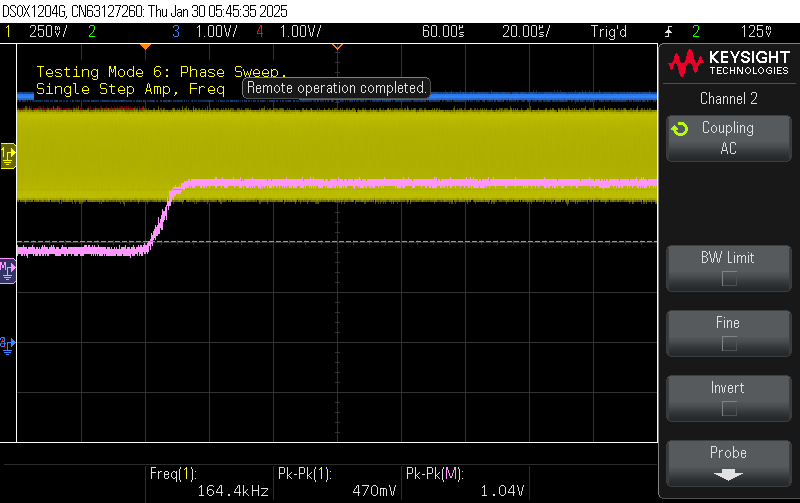

In [30]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing Mode 6: Phase Sweep, Single Step Amp, Freq"')
my_instrument.write(':TIMebase:DELay 60.0E-06')
my_instrument.write(':TIMebase:SCALe 20.0E-06')
# send('reset')

f112 = 112e6
f115 = 115e6
f118 = 118e6
f125 = 125 * MHZ
d = 0.1
t = 2000

filename = 'mode6-phasesweep2-test.png'

## set Channel Address Start Stop Delta Rate Amp Freq Time
send(
f"""abort
mode 6 1
setchannels 2
set 0 0 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 1 0 0 {d} 1 0.90 {f125} {t * 2}
set 0 2 0 0 {d} 1 0.75 {f125} {t * 2}
set 0 3 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 4 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 5 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 6 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 7 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 8 0 0 {d} 1 1.00 {f125} {t * 2}
set 0 9 0 0 {d} 1 1.00 {f125} {t * 10}
set 1 0 90 {d} 1 1.00 {f125} {t * 2}
set 1 1 90 180 {d} 1 1.00 {f125} {t * 2}
set 1 2 180 270 {d} 1 1.00 {f125} {t * 2}
set 1 3 270 360 {d} 1 1.00 {f125} {t * 2}
set 1 4 360 270 {d} 1 1.00 {f125} {t * 2}
set 1 5 270 180 {d} 1 1.00 {f125} {t * 2}
set 1 6 180 270 {d} 1 1.00 {f125} {t * 2}
set 1 7 270 180 {d} 1 1.00 {f125} {t * 2}
set 1 8 180 90 {d} 1 1.00 {f125} {t * 2}
set 1 9 90 0 {d} 1 1.00 {f125} {t * 10}
set 4 10
start
"""
)


### simple test -- still can't seem to get amplitude working
# set chan addr phase_start phase_stop delta rate amp freq (time)
# freq = 100 * MHZ
# send(
# f"""abort
# mode 6 1
# setchannels 2
# set 0 0 0 90 {d} 1 1 {freq} {t * 2}
# set 0 1 90 180 {d} 1 1 {freq} {t * 2}
# set 0 2 180 270 {d} 1 1 {freq} {t * 2}
# set 1 0 90 180 {d} 1 1 {freq} {t * 2}
# set 1 1 180 270 {d} 1 1 {freq} {t * 2}
# set 1 2 270 360 {d} 1 1 {freq} {t * 2}
# set 4 3
# start
# """
# )

# print('Success')

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

### `seti`

In [31]:
print(get_pow(90))
print(get_pow(180))
print(get_pow(270))
print(get_pow(360))
print(get_ftw(freq_out=125*MHZ))

4096
8192
12287
16383
4294967296


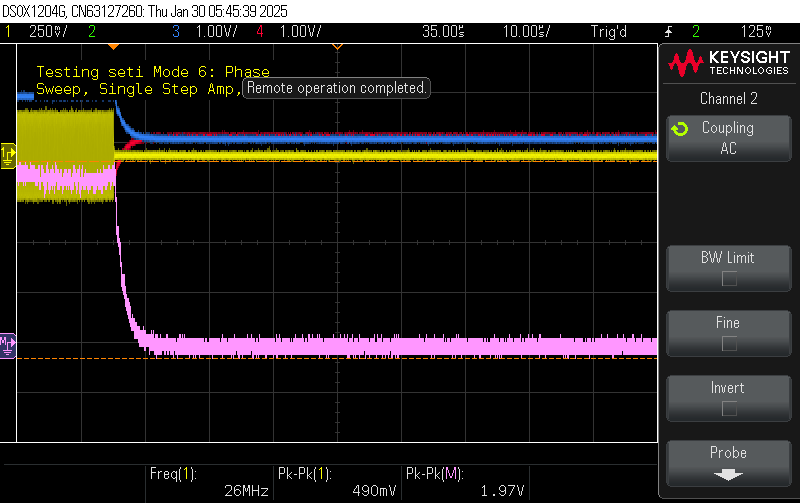

In [32]:
my_instrument.write(':DISPlay:ANNotation:TEXT "Testing seti Mode 6: Phase Sweep, Single Step Amp, Freq"')
my_instrument.write(':TIMebase:DELay 35.0E-06')
my_instrument.write(':TIMebase:SCALe 10.0E-06')

my_instrument.write(':FUNCtion:OFFSet +1.00E-00')
my_instrument.write(':FUNCtion:SCALe +500E-03')
# send('reset')

f125 = get_ftw(freq_out = 125 * MHZ)
d = 1
t = 1

filename = 'mode6-seti-phasesweep2-test.png'

send(
f"""abort
mode 6 1
setchannels 2
seti 0 0 0 0 {d} 1 1 {f125} {t}
seti 0 1 0 0 {d} 1 1 {f125} {t}
seti 0 2 0 0 {d} 1 1 {f125} {t}
seti 0 3 0 0 {d} 1 1 {f125} {t}
seti 1 0 0 4096 {d} 1 1 {f125} {t}
seti 1 1 4096 8192 {d} 1 1 {f125} {t}
seti 1 2 8192 12287 {d} 1 1 {f125} {t}
seti 1 3 12287 8192 {d} 1 1 {f125} {t}
seti 4 4
start
"""
)

# send(
# f"""abort
# mode 6 1
# setchannels 2
# seti 0 0 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 1 0 0 {d} 1 922 {f10} {t * 2}
# seti 0 2 0 0 {d} 1 768 {f10} {t * 2}
# seti 0 3 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 4 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 5 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 6 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 7 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 8 0 0 {d} 1 1023 {f10} {t * 2}
# seti 0 9 0 0 {d} 1 1023 {f10} {t * 10}
# seti 1 0 0 4096 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 1 4096 8192 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 2 8192 12287 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 3 12287 16383 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 4 16383 12287 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 5 12287 8192 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 6 8192 12287 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 7 12287 8192 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 8 8192 4096 {d} 1 {int_amp} {f10} {t * 2}
# seti 1 9 4096 0 {d} 1 {int_amp} {f10} {t * 10}
# seti 4 10
# start
# """
# )

time.sleep(1)
if SAVE_IMAGES == True:
    my_instrument.save_screenshot(filename)

if SHOW_IMAGES == True:
    display(Image(filename))

In [33]:
# my_instrument.write(':DISPlay:ANNotation:TEXT "Testing finished"')